In [1]:
from flask import Flask, jsonify, render_template, request
from flask_cors import CORS, cross_origin
import pandas as pd
from ast import literal_eval
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import boto3
from botocore.config import Config
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#Importing the relevant datasets from the mounted Google Drive (change the code below if the data is hosted elsewhere)
metadata = pd.read_csv("D:\OneDrive - NITT\Custom_Download\movies_metadata.csv")
credits = pd.read_csv("D:\OneDrive - NITT\Custom_Download\credits.csv")

In [3]:
list(metadata)

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [4]:
row = []
for i,j in enumerate(metadata['id']):
    try:
        c = int(j)
    except:
        row.append(i)

In [5]:
metadata.drop(row,inplace=True)
metadata.reset_index(drop=True,inplace=True)

In [6]:
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

In [7]:
metadata = metadata.merge(credits, on='id')

In [8]:
#Print the important features of metadata
metadata[['title', 'cast', 'crew', 'genres']].head()

,title,cast,crew,genres
0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 35, 'name': 'Comedy'}]"


In [9]:
metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45533,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de..."
45534,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
45535,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de..."
45536,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de..."


In [10]:
#raises an exception if the input isn't a valid Python datatype, so the code won't be executed if it's not.
#Parse the stringified features into their corresponding python objects

from ast import literal_eval

features = ['cast', 'crew', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

In [11]:
def f(x):
    d = []
    for i in x:
        d.append(i['name'])
    return d

In [12]:
metadata['genres'] = metadata['genres'].apply(lambda x:f(x))

In [13]:
metadata['cast'] = metadata['cast'].apply(lambda x:f(x))

In [14]:
#This function makes use of the property of the cosine similarity funciton that
#the order and types of inputs don't matter, what matters is the similarity
#between different soups of words
def create_soup(x):
    return ' '.join(x['cast']) + ' ' + ' '.join(x['genres'])

metadata['soup'] = metadata.apply(create_soup, axis=1)

In [73]:
#Getting the user's input for genre, actors and directors of their liking.
def get_genres():
    genres = input("What Movie Genre are you interested in (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] ")
    genres = " ".join(["".join(n.split()) for n in genres.lower().split(',')])
    return genres

def get_actors():
    actors = input("Who are some actors within the genre that you love (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] ")
    actors = " ".join(["".join(n.split()) for n in actors.lower().split(',')])
    return actors

def get_language():
    original_language = input("What is the spoken language (type 'en' for English and 'ar' for Arabic [Type 'skip' to skip this question] ")
    original_language = " ".join(["".join(n.split()) for n in original_language.lower().split(',')])
    return original_language
#def get_directors():
#directors = input("Who are some directors within the genre that you love (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] ")
 # directors = " ".join(["".join(n.split()) for n in directors.lower().split(',')])
# return directors

def get_keywords():
    keywords = input("What are some of the keywords that describe the movie you want to watch, like elements of the plot, whether or not it is about friendship, etc? (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] ")
    keywords = " ".join(["".join(n.split()) for n in keywords.lower().split(',')])
    return keywords

def get_searchTerms():
    searchTerms = [] 
    genres = get_genres()
    if genres and genres != 'skip':
        searchTerms.append(genres.title())
    else:
        searchTerms.append(None)

    actors = get_actors()
    if actors and actors != 'skip':
        searchTerms.append(actors.title())
    else:
        searchTerms.append(None)
    
    original_language = get_language()
    if original_language in ('en','ar'):
        searchTerms.append(original_language)
    else:
        searchTerms.append('en')
    
    return searchTerms

In [16]:
metadata = metadata.iloc[0:10000,:] # only using 10k movies

In [17]:
metadata = metadata[['title','genres','original_language','cast','soup','overview','release_date']]

In [18]:
metadata.dropna(inplace=True)

In [19]:
metadata['Year'] = metadata['release_date'].apply(lambda x:x.split('-')[0])

In [20]:
metadata.drop('release_date',axis=1,inplace=True)

In [21]:
list(metadata)

['title', 'genres', 'original_language', 'cast', 'soup', 'overview', 'Year']

# Arabic Movies Data

In [22]:
data = pd.read_csv('D:\OneDrive - NITT\Custom_Download\Arabicdata0.csv') 
data_wiki = pd.read_csv("D:\OneDrive - NITT\Custom_Download\EN&AR_data2.csv")

data.head()

,اسم الفيلم,تاريخ العرض,تصنيف الفيلم,مدة الفيلم (دقيقة),ملخص,تمثيل
0,قلب المرأة,1940,رومانسي,87,دار حدث فيلم خيري فتاه ثري مخطوب ابناء عموم تف...,"سليمان نجيب,أمينة رزق,دولت أبيض,عقيلة راتب,سلو..."
1,الورشة,1940,دراما,105,سافر سطا عبدالرحمن صاحب ورشه ميكانزم زميل رحله...,"عزيزة أمير,محمود ذو الفقار,أنور وجدي,نجمة إبرا..."
2,حياة الظلام,1940,دراما,94,عاءله متوسط حال مكون زوج زوج ٱبن حصل ٱبن اجازه...,"ميمي شكيب,محسن سرحان,روحية خالد,فردوس محمد,علي..."
3,الباشمقاول,1940,دراما,85,دار حدث فيلم محامي ممتاز هوه مغازله نساء رغم ز...,"فوزي الجزايرلي,ميمي شكيب,إحسان الجزايرلي,زوزو ..."
4,يوم سعيد,1940,رومانسي,125,محمد كمال شاب بسيط هوه موسيقي غناء عطف صاحب بي...,"محمد عبدالوهاب,علوية جميل,فاطمة محجوب,فاتن حما..."


In [23]:
data_wiki.head()

,Unnamed: 0,title/الفيلم,overview/ملخص,cast/تمثيل,genres/النوع,Year/السنة,original_language/اللغة
0,0,55 إسعاف,مجدي الهواري,محمد سعد,"دراما, اثارة",2001,ar
1,1,ابن عز,شريف عرفة,علاء ولي الدين,"دراما, اثارة",2001,ar
2,2,إحنا أصحاب المطار,شريف يحيى,فاروق الفيشاوي,"دراما, اثارة",2001,ar
3,3,اتفرج يا سلام,محمد كامل القليوبي,ماجد المصري,"دراما, اثارة",2001,ar
4,4,أسرار البنات,مجدي أحمد علي,شريف رمزي,"دراما, اثارة",2001,ar


In [24]:
data_wiki.drop('Unnamed: 0',axis=1,inplace=True)

In [25]:
data_wiki.columns= ['title', 'overview','cast','genres', 'Year','original_language']

In [26]:
data_wiki

,title,overview,cast,genres,Year,original_language
0,55 إسعاف,مجدي الهواري,محمد سعد,"دراما, اثارة",2001,ar
1,ابن عز,شريف عرفة,علاء ولي الدين,"دراما, اثارة",2001,ar
2,إحنا أصحاب المطار,شريف يحيى,فاروق الفيشاوي,"دراما, اثارة",2001,ar
3,اتفرج يا سلام,محمد كامل القليوبي,ماجد المصري,"دراما, اثارة",2001,ar
4,أسرار البنات,مجدي أحمد علي,شريف رمزي,"دراما, اثارة",2001,ar
...,...,...,...,...,...,...
299,محترم إلا ربع,محمد حمدي,محمد رجب,"دراما, اثارة",2010,ar
300,نور عيني,وائل إحسان,تامر حسني,"دراما, اثارة",2010,ar
301,هليوبوليس,أحمد عبد الله السيد,خالد أبو النجا,"دراما, اثارة",2010,ar
302,ولاد البلد,إسماعيل فاروق,سعد الصغير,"دراما, اثارة",2010,ar


In [27]:
moviesNames=data.get('اسم الفيلم')
date=data.get('تاريخ العرض')
categories=data.get('تصنيف الفيلم')
synopses=data.get('ملخص')
actors=data.get('تمثيل')

In [28]:
ae_data = pd.DataFrame()

In [29]:
ae_data['Year'] = date
ae_data['original_language'] = 'ar'
ae_data['genres'] = categories
ae_data['overview'] = synopses
ae_data['cast'] = actors
ae_data['title'] = moviesNames

In [30]:
ae_data.dropna(inplace=True)
data_wiki.dropna(inplace=True)

In [31]:
ae_data['cast'] = ae_data['cast'].apply(lambda x:x.split(','))
ae_data['genres'] = ae_data['genres'].apply(lambda x:x.split(','))

data_wiki['cast'] = data_wiki['cast'].apply(lambda x:x.split(','))
data_wiki['genres'] = data_wiki['genres'].apply(lambda x:x.split(','))

In [32]:
data_wiki.head()

,title,overview,cast,genres,Year,original_language
0,55 إسعاف,مجدي الهواري,[محمد سعد],"[دراما, اثارة]",2001,ar
1,ابن عز,شريف عرفة,[علاء ولي الدين],"[دراما, اثارة]",2001,ar
2,إحنا أصحاب المطار,شريف يحيى,[فاروق الفيشاوي],"[دراما, اثارة]",2001,ar
3,اتفرج يا سلام,محمد كامل القليوبي,[ماجد المصري],"[دراما, اثارة]",2001,ar
4,أسرار البنات,مجدي أحمد علي,[شريف رمزي],"[دراما, اثارة]",2001,ar


In [33]:
ae_data.head()

,Year,original_language,genres,overview,cast,title
0,1940,ar,[رومانسي],دار حدث فيلم خيري فتاه ثري مخطوب ابناء عموم تف...,"[سليمان نجيب, أمينة رزق, دولت أبيض, عقيلة راتب...",قلب المرأة
1,1940,ar,[دراما],سافر سطا عبدالرحمن صاحب ورشه ميكانزم زميل رحله...,"[عزيزة أمير, محمود ذو الفقار, أنور وجدي, نجمة ...",الورشة
2,1940,ar,[دراما],عاءله متوسط حال مكون زوج زوج ٱبن حصل ٱبن اجازه...,"[ميمي شكيب, محسن سرحان, روحية خالد, فردوس محمد...",حياة الظلام
3,1940,ar,[دراما],دار حدث فيلم محامي ممتاز هوه مغازله نساء رغم ز...,"[فوزي الجزايرلي, ميمي شكيب, إحسان الجزايرلي, ز...",الباشمقاول
4,1940,ar,[رومانسي],محمد كمال شاب بسيط هوه موسيقي غناء عطف صاحب بي...,"[محمد عبدالوهاب, علوية جميل, فاطمة محجوب, فاتن...",يوم سعيد


In [34]:
def create_soup_ae(x):
    return ' '.join(x['cast']) + ' ' + ' '.join(x['genres'])

In [35]:
ae_data['soup'] = ae_data.apply(create_soup_ae, axis=1)
data_wiki['soup'] = data_wiki.apply(create_soup_ae, axis=1)

In [36]:
list(ae_data)

['Year', 'original_language', 'genres', 'overview', 'cast', 'title', 'soup']

# merge both arabic data

In [37]:
arabic_full = ae_data.append(data_wiki)

In [38]:
arabic_full.shape

(1474, 7)

In [39]:
arabic_full.head()

,Year,original_language,genres,overview,cast,title,soup
0,1940,ar,[رومانسي],دار حدث فيلم خيري فتاه ثري مخطوب ابناء عموم تف...,"[سليمان نجيب, أمينة رزق, دولت أبيض, عقيلة راتب...",قلب المرأة,سليمان نجيب أمينة رزق دولت أبيض عقيلة راتب سلو...
1,1940,ar,[دراما],سافر سطا عبدالرحمن صاحب ورشه ميكانزم زميل رحله...,"[عزيزة أمير, محمود ذو الفقار, أنور وجدي, نجمة ...",الورشة,عزيزة أمير محمود ذو الفقار أنور وجدي نجمة إبرا...
2,1940,ar,[دراما],عاءله متوسط حال مكون زوج زوج ٱبن حصل ٱبن اجازه...,"[ميمي شكيب, محسن سرحان, روحية خالد, فردوس محمد...",حياة الظلام,ميمي شكيب محسن سرحان روحية خالد فردوس محمد علي...
3,1940,ar,[دراما],دار حدث فيلم محامي ممتاز هوه مغازله نساء رغم ز...,"[فوزي الجزايرلي, ميمي شكيب, إحسان الجزايرلي, ز...",الباشمقاول,فوزي الجزايرلي ميمي شكيب إحسان الجزايرلي زوزو ...
4,1940,ar,[رومانسي],محمد كمال شاب بسيط هوه موسيقي غناء عطف صاحب بي...,"[محمد عبدالوهاب, علوية جميل, فاطمة محجوب, فاتن...",يوم سعيد,محمد عبدالوهاب علوية جميل فاطمة محجوب فاتن حما...


# merge arabic and english data

In [40]:
data_full = metadata.append(arabic_full)

In [41]:
data_full

,title,genres,original_language,cast,soup,overview,Year
0,Toy Story,"[Animation, Comedy, Family]",en,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",Tom Hanks Tim Allen Don Rickles Jim Varney Wal...,"Led by Woody, Andy's toys live happily in his ...",1995
1,Jumanji,"[Adventure, Fantasy, Family]",en,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Robin Williams Jonathan Hyde Kirsten Dunst Bra...,When siblings Judy and Peter discover an encha...,1995
2,Grumpier Old Men,"[Romance, Comedy]",en,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Walter Matthau Jack Lemmon Ann-Margret Sophia ...,A family wedding reignites the ancient feud be...,1995
3,Waiting to Exhale,"[Comedy, Drama, Romance]",en,"[Whitney Houston, Angela Bassett, Loretta Devi...",Whitney Houston Angela Bassett Loretta Devine ...,"Cheated on, mistreated and stepped on, the wom...",1995
4,Father of the Bride Part II,[Comedy],en,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Steve Martin Diane Keaton Martin Short Kimberl...,Just when George Banks has recovered from his ...,1995
...,...,...,...,...,...,...,...
299,محترم إلا ربع,"[دراما, اثارة]",ar,[محمد رجب],محمد رجب دراما اثارة,محمد حمدي,2010
300,نور عيني,"[دراما, اثارة]",ar,[تامر حسني],تامر حسني دراما اثارة,وائل إحسان,2010
301,هليوبوليس,"[دراما, اثارة]",ar,[خالد أبو النجا],خالد أبو النجا دراما اثارة,أحمد عبد الله السيد,2010
302,ولاد البلد,"[دراما, اثارة]",ar,[سعد الصغير],سعد الصغير دراما اثارة,إسماعيل فاروق,2010


# SAVE the data

In [42]:
data_full.to_csv('full_data.csv',index=False)

# EDA

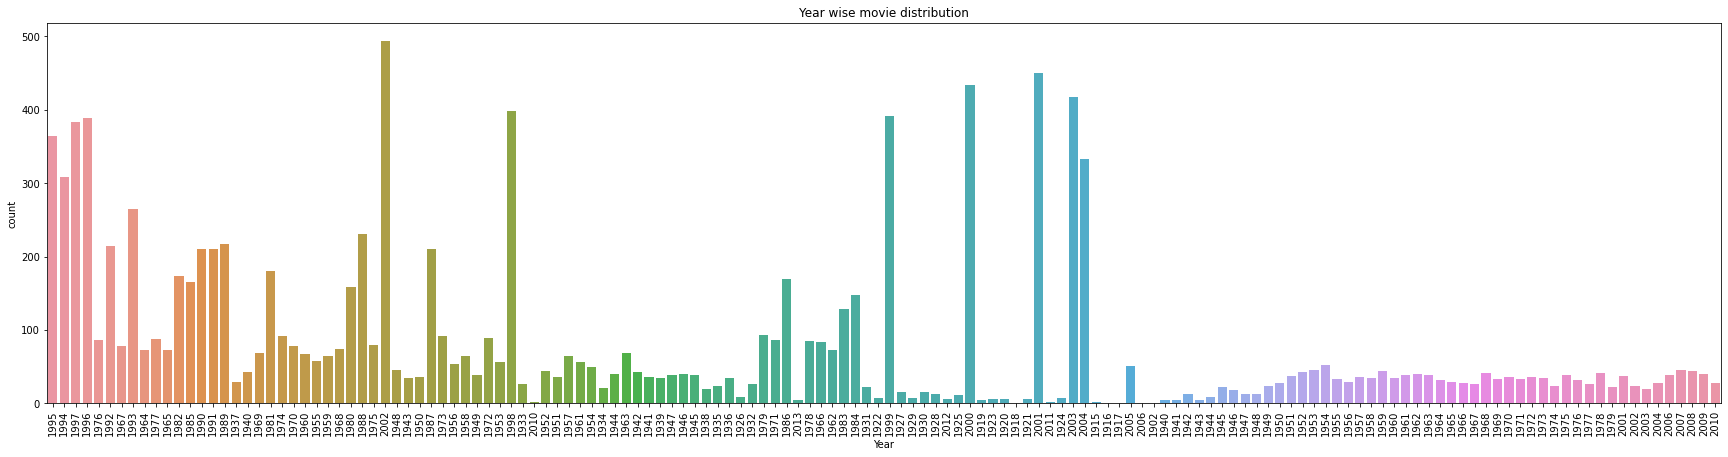

In [43]:
plt.figure(figsize=(30,7))
plt.title('Year wise movie distribution')
sns.countplot(data_full['Year'])
plt.xticks(rotation=90)
plt.show()

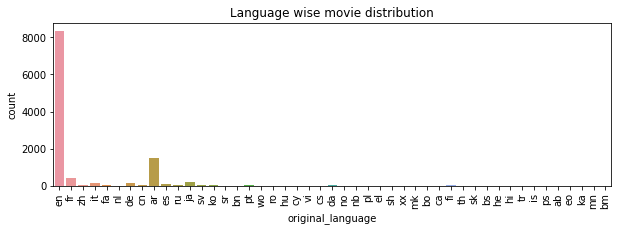

In [44]:
plt.figure(figsize=(10,3))
plt.title('Language wise movie distribution')
sns.countplot(data_full['original_language'])
plt.xticks(rotation=90)
plt.show()

# filter data so that it contains movie in english and arabic only

In [45]:
data_full = data_full[data_full['original_language'].isin(['en','ar'])]

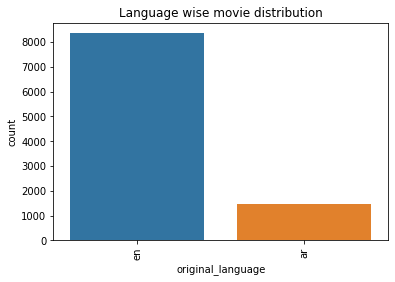

In [46]:
# plt.figure(figsize=(5))
plt.title('Language wise movie distribution')
sns.countplot(data_full['original_language'])
plt.xticks(rotation=90)
plt.show()

In [47]:
category = []
from tqdm.notebook import tqdm
for cat in tqdm(data_full[data_full['original_language'].isin(['en'])]['genres']):
    category = category + cat

  0%|          | 0/8357 [00:00<?, ?it/s]

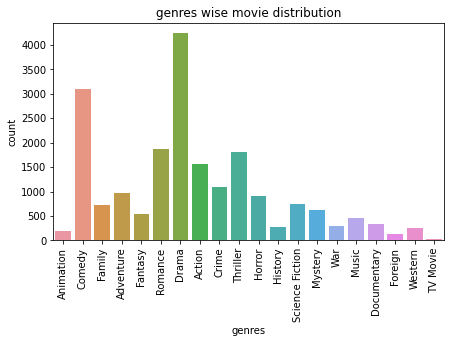

In [48]:
# Engligh movies
plt.figure(figsize=(7,4))
plt.title('genres wise movie distribution')
sns.countplot(category)
plt.xticks(rotation=90)
plt.xlabel('genres')
plt.show()

In [49]:
category = []
for cat in tqdm(data_full[data_full['original_language'].isin(['ar'])]['genres']):
    category = category + cat
    
category = [i for i in category if len(i)<=40]

  0%|          | 0/1476 [00:00<?, ?it/s]

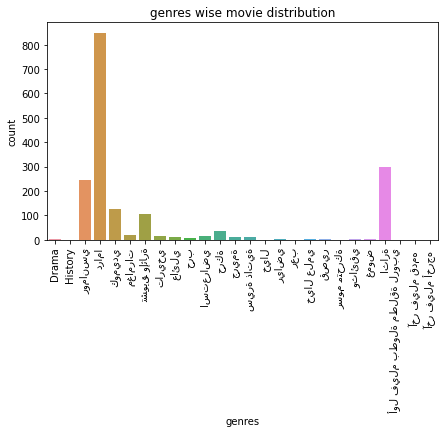

In [50]:
# arabic movies
plt.figure(figsize=(7,4))
plt.title('genres wise movie distribution')
sns.countplot(category)
plt.xticks(rotation=90)
plt.xlabel('genres')
plt.show()

In [51]:
# Engligh movies
category = []
from tqdm.notebook import tqdm
for cat in tqdm(data_full[data_full['original_language'].isin(['en'])]['cast']):
    category = category + cat

  0%|          | 0/8357 [00:00<?, ?it/s]

In [52]:
d = dict(sorted(Counter(category).items(),key=lambda x:x[1],reverse=True)[:50])

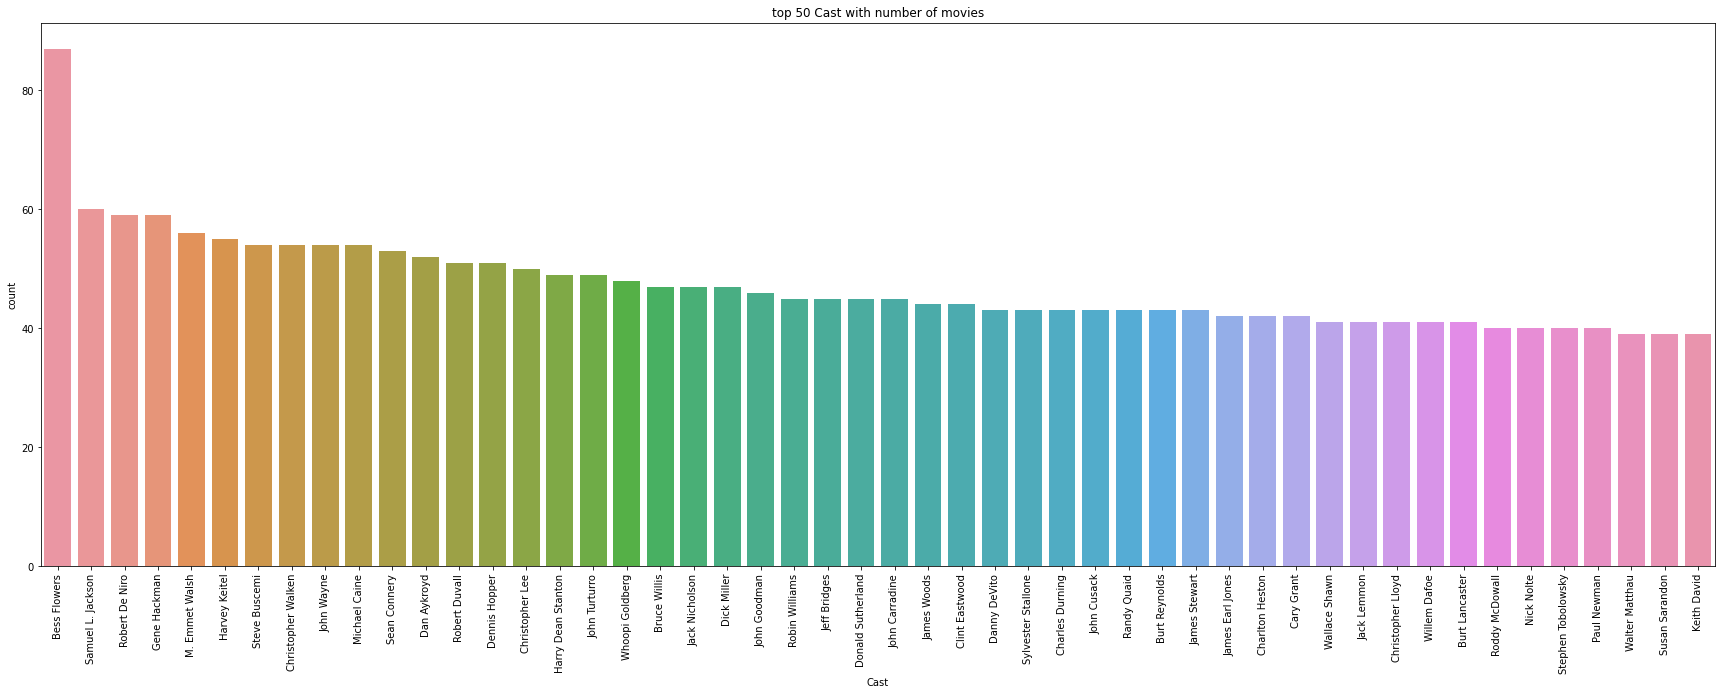

In [53]:
all_cast = []
for i in d:
    all_cast = all_cast + [i]*d[i]
    
plt.figure(figsize=(30,10))
plt.title('top 50 Cast with number of movies')
sns.countplot(all_cast)
plt.xticks(rotation=90)
plt.xlabel('Cast')
plt.show()

  0%|          | 0/1476 [00:00<?, ?it/s]

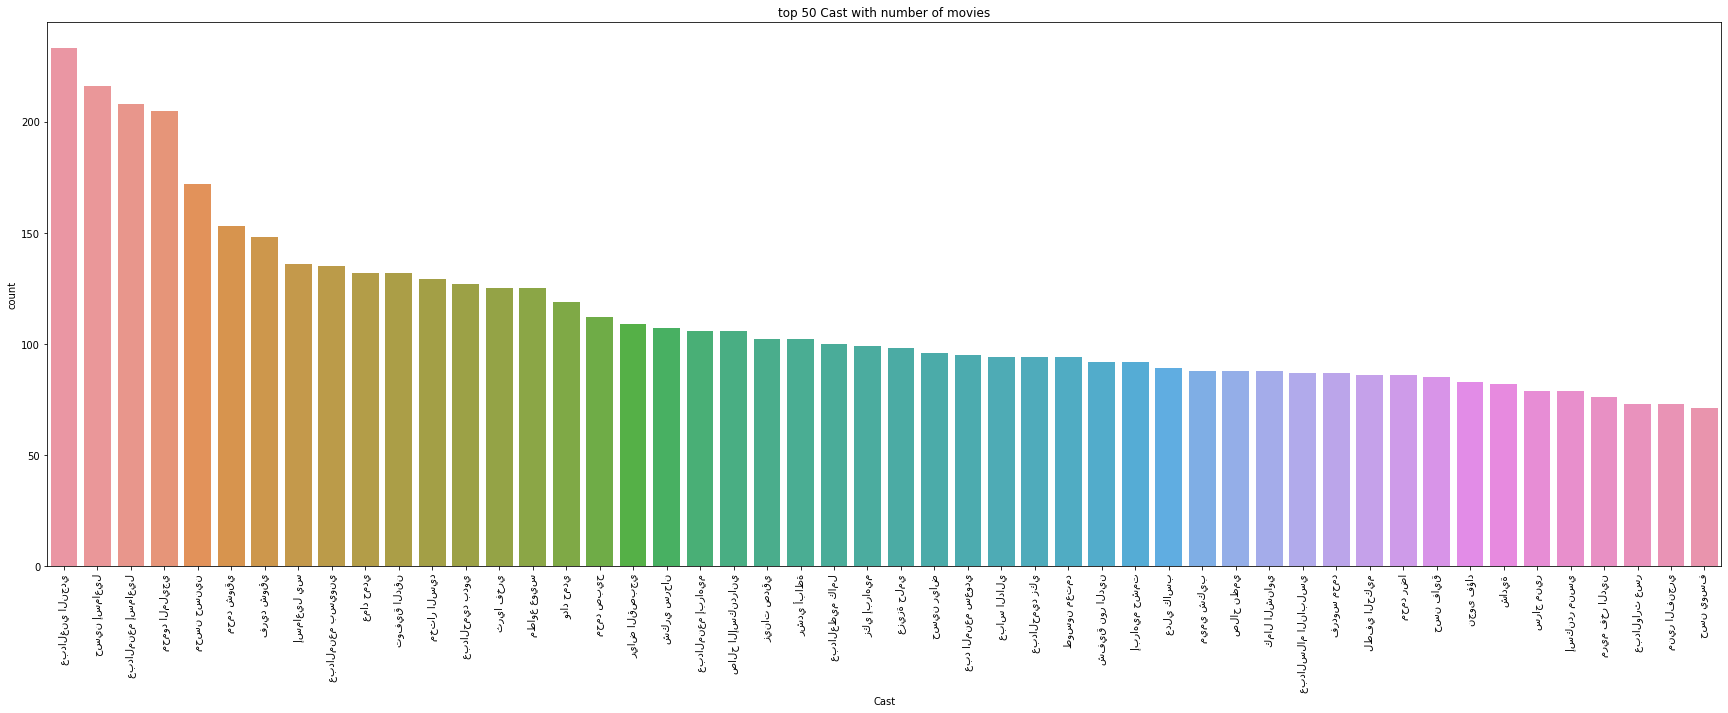

In [54]:
# arabic movies
category = []
from tqdm.notebook import tqdm
for cat in tqdm(data_full[data_full['original_language'].isin(['ar'])]['cast']):
    category = category + cat
    
d = dict(sorted(Counter(category).items(),key=lambda x:x[1],reverse=True)[:50])
all_cast = []
for i in d:
    all_cast = all_cast + [i]*d[i]
    
plt.figure(figsize=(30,10))
plt.title('top 50 Cast with number of movies')
sns.countplot(all_cast)
plt.xticks(rotation=90)
plt.xlabel('Cast')
plt.show()

In [55]:
!pip install pyarabic

In [56]:
import pyarabic.araby as araby
from nltk.corpus import stopwords
import re

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

In [57]:
# Arabic stop words with nltk
stop_words = stopwords.words('arabic')
stop_words_ae = [normalizeArabic(word) for word in stop_words]

# recommendation

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def make_recommendation(metadata=data_full):

    #grabbing the new wordsoup from the user
    searchTerms = get_searchTerms()  
#     print(searchTerms)
    ################# filter dataframe for recommendation #################
    
    if searchTerms[2]:
        metadata_copy = metadata[metadata['original_language']==searchTerms[2].lower()]

    if searchTerms[0]:
        
        f_data = metadata_copy[metadata_copy['genres'].apply(lambda x: any(t.strip().title() in x for t in searchTerms[0].split(',')))]
#         f_data = metadata_copy[metadata_copy['genres'].apply(lambda x: searchTerms[0] in x)]
        if len(f_data):
            metadata_copy = f_data
            
    if searchTerms[1]:
        
        f = lambda x: any(t.strip().title() in ' '.join(x).split() for t in searchTerms[1].split(','))
        
        f_data = metadata_copy[metadata_copy['cast'].apply(f)]
        

#         f_data = metadata_copy[metadata_copy['cast'].apply(lambda x: searchTerms[1] in ' '.join(x).split())]
        if len(f_data):
            metadata_copy = f_data
    #######################################################################
    
    #Vectorizing the entire matrix as described above!
    
    if searchTerms[2].lower() == 'en':
        count = CountVectorizer(stop_words='english')
    else:
        count = CountVectorizer(stop_words=stop_words_ae)
        
    count_matrix = count.fit_transform(metadata_copy['soup'])

    #running pairwise cosine similarity 
    cosine_sim2 = cosine_similarity(count_matrix, count_matrix) #getting a similarity matrix

    #sorting cosine similarities by highest to lowest
    sim_scores = list(enumerate(cosine_sim2[-1,:]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     print(sim_scores)
    #matching the simix
    # similarities to the movie titles and ids
    ranked_titles = []
    for i in range(1, 11):
        try:
            indx = sim_scores[i][0]
            ranked_titles.append([metadata_copy['title'].iloc[indx]])
        except:
            pass
    ranked_titles = pd.DataFrame(np.array(ranked_titles)[:,0],columns=['Title'])
    return ranked_titles

In [78]:
#let's try our recommendation function now
print(make_recommendation())

What Movie Genre are you interested in (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] comedy,action
Who are some actors within the genre that you love (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] tom
What is the spoken language (type 'en' for English and 'ar' for Arabic [Type 'skip' to skip this question] 
['Comedy Action', 'Tom', 'en']
                               Title
0                      The Big Sleep
1                        San Antonio
2       Mr. Smith Goes to Washington
3                      South Pacific
4                               Tess
5                   The Great Escape
6                         Humoresque
7  At Play in the Fields of the Lord
8                             Gandhi
9                              Hoffa


In [80]:
print(make_recommendation())

What Movie Genre are you interested in (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] دراما
Who are some actors within the genre that you love (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] 
What is the spoken language (type 'en' for English and 'ar' for Arabic [Type 'skip' to skip this question] ar
['دراما', None, 'ar']
                  Title
0       علشان ربنا يحبك
1              إوعى وشك
2      حوش اللي وقع منك
3              أفريكانو
4          أيام السادات
5  الرجل الأبيض المتوسط
6        شباب على الهوا
7                 مافيا
8          معالي الوزير
9             فيلم هندي


In [94]:
print(make_recommendation())

What Movie Genre are you interested in (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] تامر حسني
Who are some actors within the genre that you love (if multiple, please separate them with a comma)? [Type 'skip' to skip this question] skip
What is the spoken language (type 'en' for English and 'ar' for Arabic [Type 'skip' to skip this question] ar
                  Title
0       علشان ربنا يحبك
1              إوعى وشك
2      حوش اللي وقع منك
3              أفريكانو
4          أيام السادات
5  الرجل الأبيض المتوسط
6        شباب على الهوا
7                 مافيا
8          معالي الوزير
9             فيلم هندي
